# Diffie-Hellman Key Exchange

## Introduction

The Diffie-Hellman key exchange, introduced by Whitfield Diffie and Martin Hellman in 1976, is a foundational cryptographic protocol that enables two parties to establish a shared secret over an insecure communication channel. This shared secret can subsequently be used for symmetric encryption of further communications.

## Mathematical Foundation

### Discrete Logarithm Problem

The security of Diffie-Hellman relies on the computational difficulty of the **discrete logarithm problem**. Given a cyclic group $G$ of order $n$ with generator $g$, the discrete logarithm of an element $h \in G$ is the integer $x$ satisfying:

$$g^x \equiv h \pmod{p}$$

While computing $g^x \mod p$ is efficient (via modular exponentiation), finding $x$ given $g^x$ is computationally intractable for sufficiently large primes.

### Protocol Description

Two parties, Alice and Bob, agree on public parameters:
- A large prime $p$
- A primitive root (generator) $g$ modulo $p$

**Key Exchange Steps:**

1. **Alice's private key:** Alice selects a random private integer $a$ where $1 < a < p-1$
2. **Alice's public key:** Alice computes $A = g^a \mod p$ and sends $A$ to Bob
3. **Bob's private key:** Bob selects a random private integer $b$ where $1 < b < p-1$
4. **Bob's public key:** Bob computes $B = g^b \mod p$ and sends $B$ to Alice
5. **Shared secret computation:**
   - Alice computes: $s = B^a \mod p = (g^b)^a \mod p = g^{ab} \mod p$
   - Bob computes: $s = A^b \mod p = (g^a)^b \mod p = g^{ab} \mod p$

Both parties now possess the same shared secret $s = g^{ab} \mod p$.

### Security Properties

An eavesdropper observing $g$, $p$, $A = g^a \mod p$, and $B = g^b \mod p$ cannot efficiently compute $g^{ab} \mod p$ without solving the discrete logarithm problem. This is known as the **Computational Diffie-Hellman (CDH) assumption**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint, seed
import time

# Set random seed for reproducibility
seed(42)
np.random.seed(42)

## Implementation

### Helper Functions

We first implement essential number-theoretic functions for the Diffie-Hellman protocol.

In [2]:
def mod_exp(base, exp, mod):
    """
    Compute base^exp mod mod using fast modular exponentiation.
    
    Uses the square-and-multiply algorithm with complexity O(log exp).
    
    Parameters:
    -----------
    base : int
        The base value
    exp : int
        The exponent
    mod : int
        The modulus
    
    Returns:
    --------
    int
        base^exp mod mod
    """
    result = 1
    base = base % mod
    while exp > 0:
        if exp % 2 == 1:
            result = (result * base) % mod
        exp = exp >> 1
        base = (base * base) % mod
    return result


def is_prime(n, k=20):
    """
    Miller-Rabin primality test.
    
    Parameters:
    -----------
    n : int
        Number to test for primality
    k : int
        Number of rounds (higher = more accurate)
    
    Returns:
    --------
    bool
        True if n is probably prime, False if composite
    """
    if n < 2:
        return False
    if n == 2 or n == 3:
        return True
    if n % 2 == 0:
        return False
    
    # Write n-1 as 2^r * d
    r, d = 0, n - 1
    while d % 2 == 0:
        r += 1
        d //= 2
    
    # Witness loop
    for _ in range(k):
        a = randint(2, n - 2)
        x = mod_exp(a, d, n)
        
        if x == 1 or x == n - 1:
            continue
        
        for _ in range(r - 1):
            x = mod_exp(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    
    return True


def generate_prime(bits):
    """
    Generate a random prime number with specified bit length.
    
    Parameters:
    -----------
    bits : int
        Desired bit length of the prime
    
    Returns:
    --------
    int
        A prime number with the specified bit length
    """
    while True:
        # Generate odd number in range [2^(bits-1), 2^bits - 1]
        n = randint(2**(bits-1), 2**bits - 1)
        n |= 1  # Ensure odd
        if is_prime(n):
            return n


def find_primitive_root(p):
    """
    Find a primitive root modulo p (a safe prime).
    
    For a safe prime p = 2q + 1, g is a primitive root if:
    g^2 != 1 (mod p) and g^q != 1 (mod p)
    
    Parameters:
    -----------
    p : int
        A prime number
    
    Returns:
    --------
    int
        A primitive root modulo p
    """
    if p == 2:
        return 1
    
    # Factor p-1
    phi = p - 1
    factors = []
    n = phi
    
    # Find prime factors of phi
    for i in [2] + list(range(3, int(n**0.5) + 1, 2)):
        if n % i == 0:
            factors.append(i)
            while n % i == 0:
                n //= i
    if n > 1:
        factors.append(n)
    
    # Find primitive root
    for g in range(2, p):
        is_primitive = True
        for factor in factors:
            if mod_exp(g, phi // factor, p) == 1:
                is_primitive = False
                break
        if is_primitive:
            return g
    
    return None


def brute_force_discrete_log(g, h, p):
    """
    Attempt to find x such that g^x = h (mod p) by brute force.
    
    Parameters:
    -----------
    g : int
        Generator
    h : int
        Target value (public key)
    p : int
        Prime modulus
    
    Returns:
    --------
    tuple
        (x, iterations) if found, (None, iterations) otherwise
    """
    iterations = 0
    for x in range(1, p):
        iterations += 1
        if mod_exp(g, x, p) == h:
            return x, iterations
    return None, iterations

### Diffie-Hellman Protocol Implementation

In [3]:
class DiffieHellman:
    """
    Implementation of the Diffie-Hellman key exchange protocol.
    """
    
    def __init__(self, p=None, g=None, key_bits=32):
        """
        Initialize Diffie-Hellman parameters.
        
        Parameters:
        -----------
        p : int, optional
            Prime modulus
        g : int, optional
            Generator (primitive root)
        key_bits : int
            Bit length for generated prime if p not provided
        """
        if p is None:
            self.p = generate_prime(key_bits)
        else:
            self.p = p
        
        if g is None:
            self.g = find_primitive_root(self.p)
        else:
            self.g = g
        
        # Generate private key
        self.private_key = randint(2, self.p - 2)
        
        # Compute public key: g^private_key mod p
        self.public_key = mod_exp(self.g, self.private_key, self.p)
    
    def compute_shared_secret(self, other_public_key):
        """
        Compute the shared secret given the other party's public key.
        
        Parameters:
        -----------
        other_public_key : int
            The public key received from the other party
        
        Returns:
        --------
        int
            The shared secret
        """
        return mod_exp(other_public_key, self.private_key, self.p)

## Demonstration

### Basic Key Exchange

In [4]:
# Generate public parameters
print("=" * 60)
print("DIFFIE-HELLMAN KEY EXCHANGE DEMONSTRATION")
print("=" * 60)

# Use a small prime for demonstration (to avoid kernel timeout)
# In practice, 2048+ bit primes are used
p = generate_prime(24)
g = find_primitive_root(p)

print(f"\nPublic Parameters:")
print(f"  Prime p = {p}")
print(f"  Generator g = {g}")

# Alice's side
alice = DiffieHellman(p, g)
print(f"\nAlice:")
print(f"  Private key a = {alice.private_key}")
print(f"  Public key A = g^a mod p = {alice.public_key}")

# Bob's side
bob = DiffieHellman(p, g)
print(f"\nBob:")
print(f"  Private key b = {bob.private_key}")
print(f"  Public key B = g^b mod p = {bob.public_key}")

# Compute shared secrets
alice_secret = alice.compute_shared_secret(bob.public_key)
bob_secret = bob.compute_shared_secret(alice.public_key)

print(f"\nShared Secret Computation:")
print(f"  Alice computes: B^a mod p = {alice_secret}")
print(f"  Bob computes:   A^b mod p = {bob_secret}")
print(f"\n  Secrets match: {alice_secret == bob_secret}")
print("=" * 60)

DIFFIE-HELLMAN KEY EXCHANGE DEMONSTRATION

Public Parameters:
  Prime p = 12133463
  Generator g = 5

Alice:
  Private key a = 9142602
  Public key A = g^a mod p = 5269537

Bob:
  Private key b = 7038376
  Public key B = g^b mod p = 5989321

Shared Secret Computation:
  Alice computes: B^a mod p = 3273469
  Bob computes:   A^b mod p = 3273469

  Secrets match: True


## Security Analysis

### Computational Complexity of Discrete Logarithm

We now analyze the computational difficulty of attacking Diffie-Hellman by attempting to solve the discrete logarithm problem using brute force.

In [5]:
# Measure attack time for different key sizes
# Using smaller key sizes to prevent kernel timeout during brute force
key_sizes = [8, 10, 12, 14, 16]
attack_times = []
key_space_sizes = []

print("Discrete Logarithm Attack Analysis")
print("-" * 50)

for bits in key_sizes:
    # Generate parameters
    p_test = generate_prime(bits)
    g_test = find_primitive_root(p_test)

    # Create a key exchange
    test_dh = DiffieHellman(p_test, g_test)

    # Time the brute force attack
    start = time.time()
    found_key, iterations = brute_force_discrete_log(
        g_test, test_dh.public_key, p_test
    )
    elapsed = time.time() - start

    attack_times.append(elapsed)
    key_space_sizes.append(p_test - 1)

    print(f"Bits: {bits:2d} | Prime: {p_test:20d} | "
          f"Time: {elapsed:.4f}s | Iterations: {iterations}")

print("-" * 50)

Discrete Logarithm Attack Analysis
--------------------------------------------------
Bits:  8 | Prime:                  199 | Time: 0.0002s | Iterations: 188
Bits: 10 | Prime:                  983 | Time: 0.0011s | Iterations: 793
Bits: 12 | Prime:                 3001 | Time: 0.0047s | Iterations: 2988
Bits: 14 | Prime:                12203 | Time: 0.0074s | Iterations: 5157
Bits: 16 | Prime:                46703 | Time: 0.0524s | Iterations: 32345
--------------------------------------------------


## Visualization

### Key Exchange Process and Security Analysis

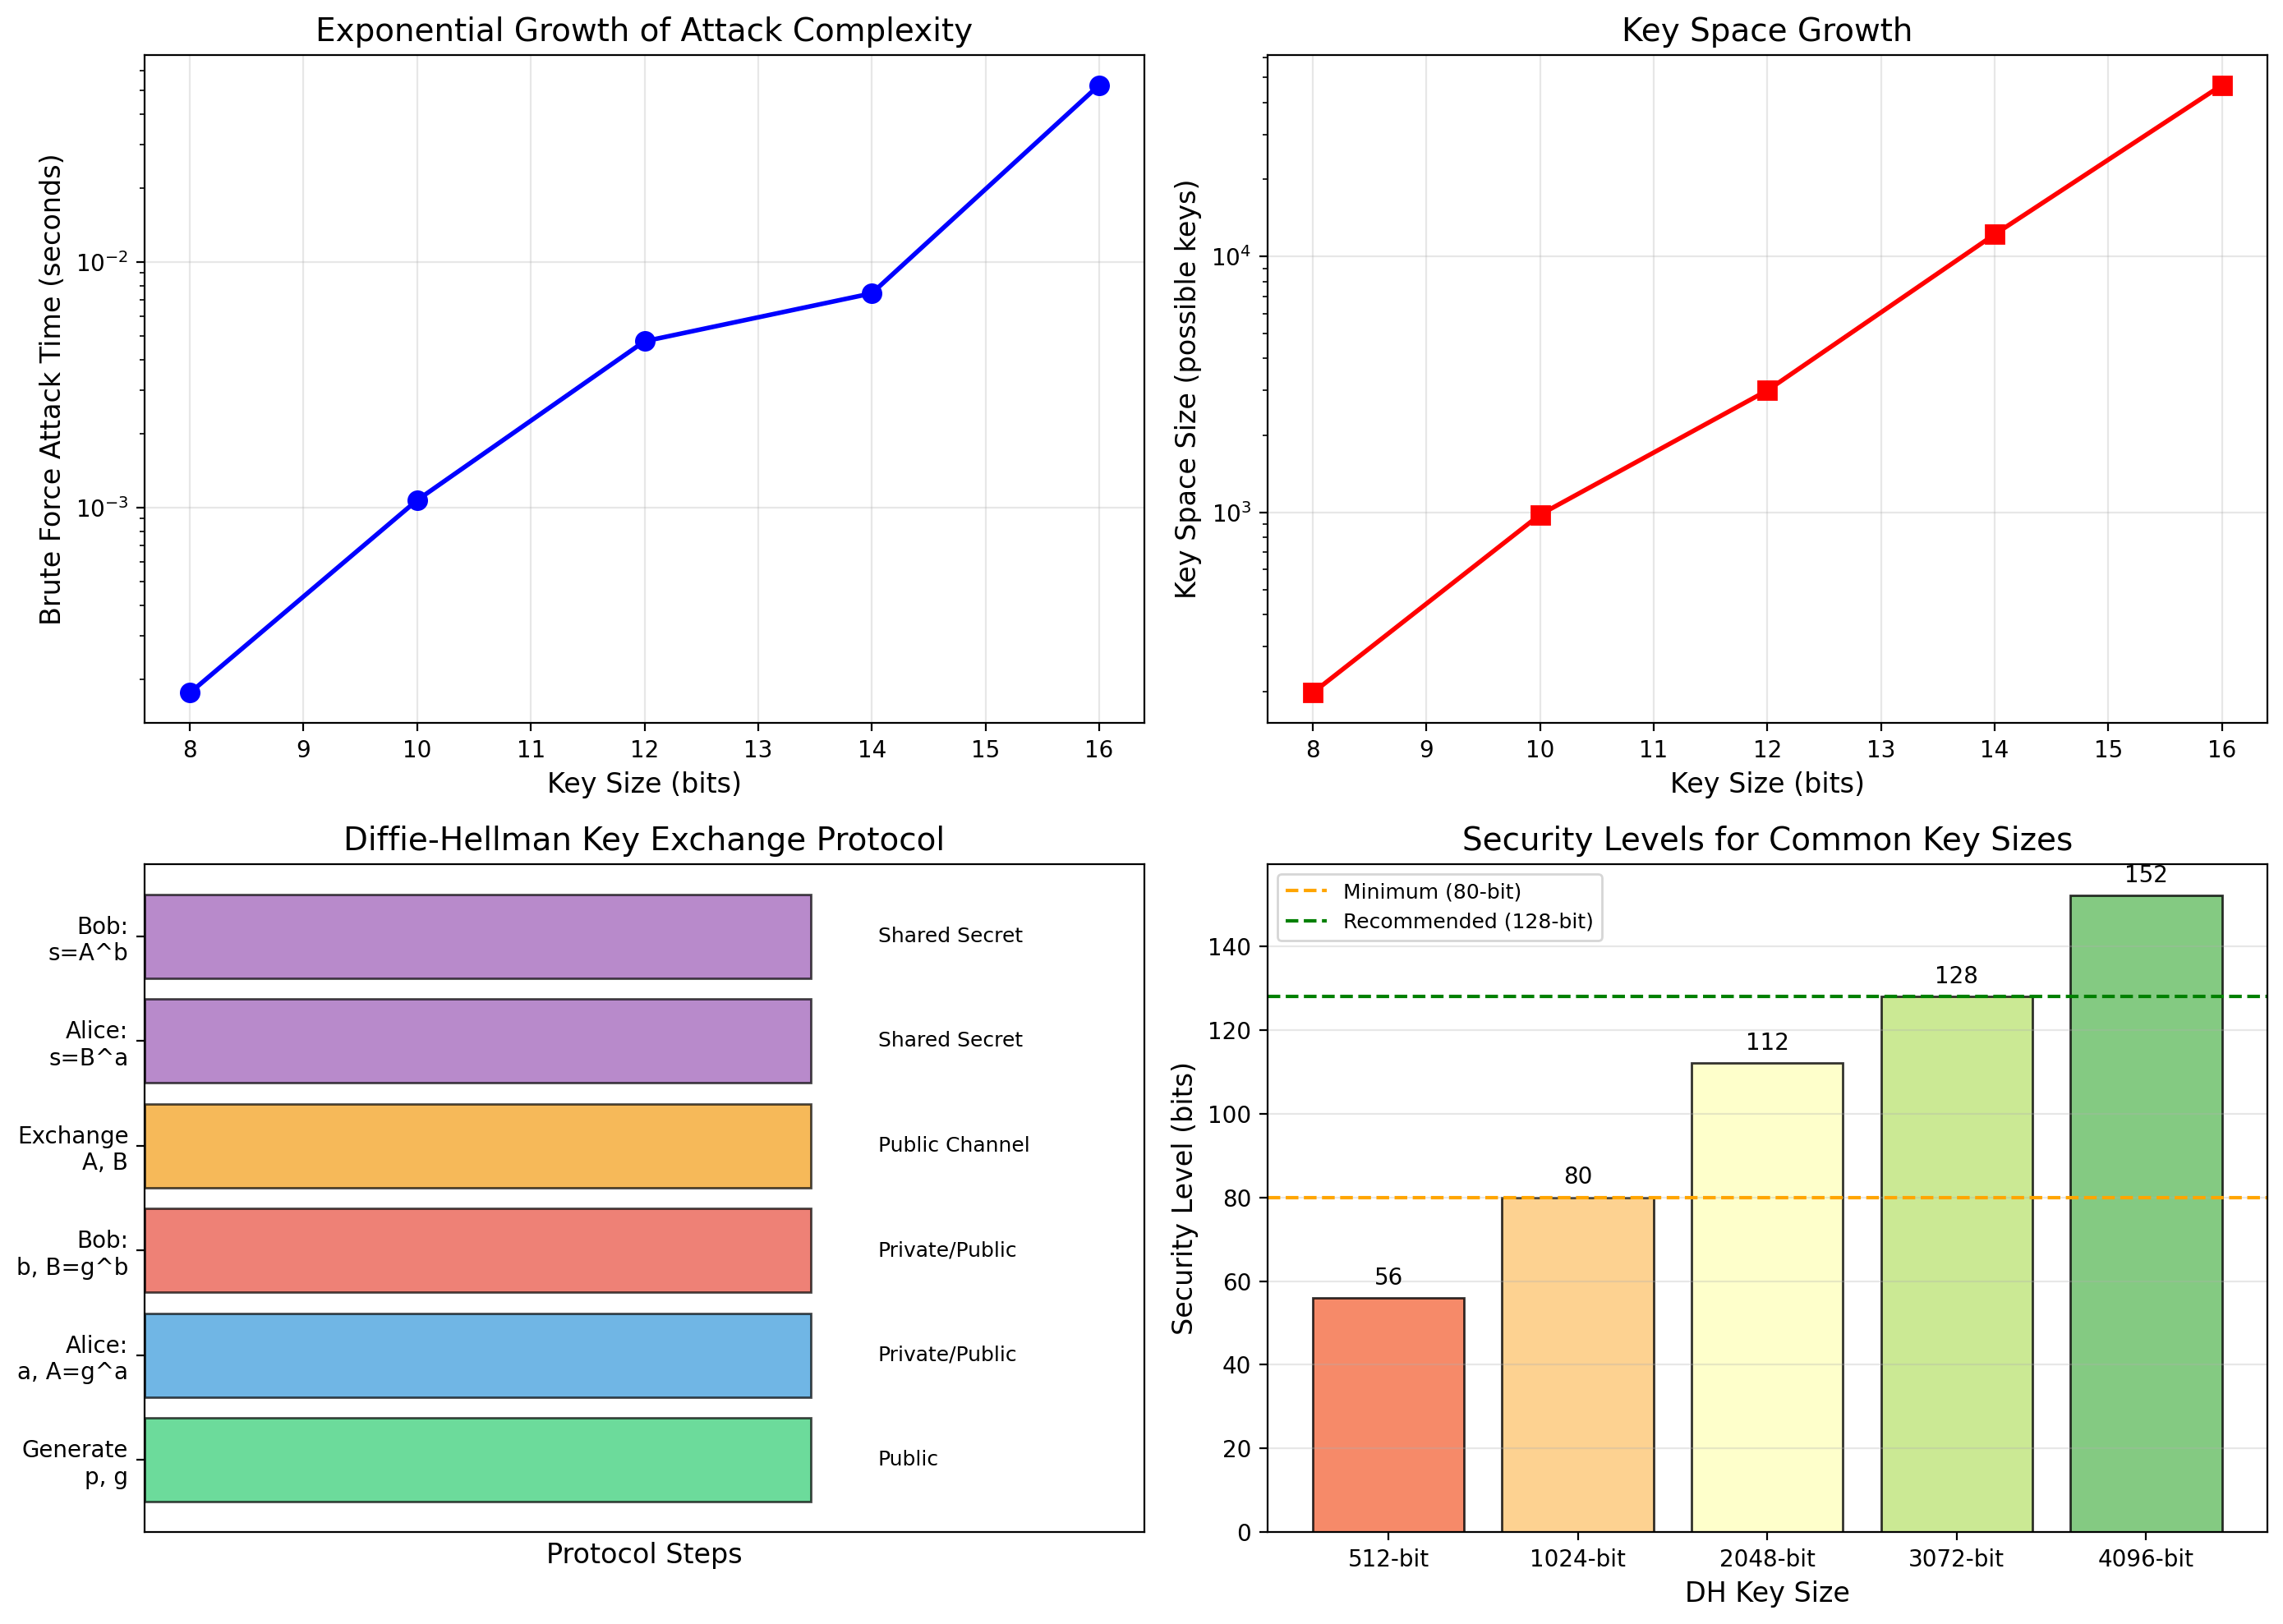


Plot saved to 'plot.png'


In [6]:
fig = plt.figure(figsize=(14, 10))

# Plot 1: Attack time vs key size (exponential growth)
ax1 = fig.add_subplot(2, 2, 1)
ax1.semilogy(key_sizes, attack_times, 'b-o', linewidth=2, markersize=8)
ax1.set_xlabel('Key Size (bits)', fontsize=12)
ax1.set_ylabel('Brute Force Attack Time (seconds)', fontsize=12)
ax1.set_title('Exponential Growth of Attack Complexity', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot 2: Key space size growth
ax2 = fig.add_subplot(2, 2, 2)
ax2.semilogy(key_sizes, key_space_sizes, 'r-s', linewidth=2, markersize=8)
ax2.set_xlabel('Key Size (bits)', fontsize=12)
ax2.set_ylabel('Key Space Size (possible keys)', fontsize=12)
ax2.set_title('Key Space Growth', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Visualization of the key exchange process
ax3 = fig.add_subplot(2, 2, 3)

# Create a visual representation of the protocol
steps = ['Generate\np, g', 'Alice:\na, A=g^a', 'Bob:\nb, B=g^b', 
         'Exchange\nA, B', 'Alice:\ns=B^a', 'Bob:\ns=A^b']
y_pos = np.arange(len(steps))
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#9b59b6']

bars = ax3.barh(y_pos, [1]*len(steps), color=colors, alpha=0.7, edgecolor='black')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(steps, fontsize=10)
ax3.set_xlabel('Protocol Steps', fontsize=12)
ax3.set_title('Diffie-Hellman Key Exchange Protocol', fontsize=14)
ax3.set_xlim(0, 1.5)
ax3.set_xticks([])

# Add annotations
annotations = ['Public', 'Private/Public', 'Private/Public', 
               'Public Channel', 'Shared Secret', 'Shared Secret']
for i, (bar, ann) in enumerate(zip(bars, annotations)):
    ax3.text(1.1, i, ann, va='center', fontsize=9)

# Plot 4: Security comparison for different key sizes
ax4 = fig.add_subplot(2, 2, 4)

# Estimated security levels (simplified)
common_key_sizes = [512, 1024, 2048, 3072, 4096]
security_bits = [56, 80, 112, 128, 152]  # Approximate security level

colors_security = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(common_key_sizes)))
bars = ax4.bar(range(len(common_key_sizes)), security_bits, 
               color=colors_security, edgecolor='black', alpha=0.8)

ax4.set_xticks(range(len(common_key_sizes)))
ax4.set_xticklabels([f'{s}-bit' for s in common_key_sizes], fontsize=10)
ax4.set_ylabel('Security Level (bits)', fontsize=12)
ax4.set_xlabel('DH Key Size', fontsize=12)
ax4.set_title('Security Levels for Common Key Sizes', fontsize=14)
ax4.axhline(y=80, color='orange', linestyle='--', label='Minimum (80-bit)')
ax4.axhline(y=128, color='green', linestyle='--', label='Recommended (128-bit)')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, security_bits):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('diffie_hellman_key_exchange_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Extended Analysis: Man-in-the-Middle Vulnerability

The basic Diffie-Hellman protocol is vulnerable to **Man-in-the-Middle (MITM) attacks** since it provides no authentication. An attacker can intercept and replace public keys.

In [7]:
print("\n" + "=" * 60)
print("MAN-IN-THE-MIDDLE ATTACK DEMONSTRATION")
print("=" * 60)

# Generate shared parameters (using small prime for demonstration)
p_mitm = generate_prime(20)
g_mitm = find_primitive_root(p_mitm)

# Legitimate parties
alice_mitm = DiffieHellman(p_mitm, g_mitm)
bob_mitm = DiffieHellman(p_mitm, g_mitm)

# Attacker (Eve) creates two DH instances
eve_to_alice = DiffieHellman(p_mitm, g_mitm)
eve_to_bob = DiffieHellman(p_mitm, g_mitm)

print(f"\nPublic parameters: p = {p_mitm}, g = {g_mitm}")
print(f"\nAlice's public key: {alice_mitm.public_key}")
print(f"Bob's public key: {bob_mitm.public_key}")

print(f"\nEve intercepts and substitutes:")
print(f"  To Alice (pretending to be Bob): {eve_to_alice.public_key}")
print(f"  To Bob (pretending to be Alice): {eve_to_bob.public_key}")

# Compute compromised shared secrets
alice_thinks_bob = alice_mitm.compute_shared_secret(eve_to_alice.public_key)
eve_with_alice = eve_to_alice.compute_shared_secret(alice_mitm.public_key)

bob_thinks_alice = bob_mitm.compute_shared_secret(eve_to_bob.public_key)
eve_with_bob = eve_to_bob.compute_shared_secret(bob_mitm.public_key)

print(f"\nCompromised secrets:")
print(f"  Alice <-> Eve: {alice_thinks_bob} (Alice) = {eve_with_alice} (Eve)")
print(f"  Eve <-> Bob:   {eve_with_bob} (Eve) = {bob_thinks_alice} (Bob)")

print(f"\nEve can now:")
print(f"  - Decrypt messages from Alice using secret {eve_with_alice}")
print(f"  - Re-encrypt for Bob using secret {eve_with_bob}")
print(f"  - And vice versa, without detection!")
print("=" * 60)


MAN-IN-THE-MIDDLE ATTACK DEMONSTRATION

Public parameters: p = 619613, g = 2

Alice's public key: 402028
Bob's public key: 374674

Eve intercepts and substitutes:
  To Alice (pretending to be Bob): 49680
  To Bob (pretending to be Alice): 242877

Compromised secrets:
  Alice <-> Eve: 117959 (Alice) = 117959 (Eve)
  Eve <-> Bob:   43725 (Eve) = 43725 (Bob)

Eve can now:
  - Decrypt messages from Alice using secret 117959
  - Re-encrypt for Bob using secret 43725
  - And vice versa, without detection!


## Conclusions

### Key Takeaways

1. **Mathematical Security**: The Diffie-Hellman protocol's security relies on the computational intractability of the discrete logarithm problem. For sufficiently large primes (≥2048 bits), brute force attacks become infeasible.

2. **Exponential Complexity**: The attack time grows exponentially with key size, as demonstrated in our analysis. Modern implementations use key sizes of 2048 bits or larger.

3. **Authentication Required**: The basic protocol is vulnerable to MITM attacks. In practice, DH is combined with authentication mechanisms (digital signatures, certificates) to prevent this.

4. **Modern Applications**: Diffie-Hellman and its elliptic curve variant (ECDH) remain fundamental to:
   - TLS/SSL handshakes
   - SSH key exchange
   - IPsec VPN connections
   - Signal Protocol (end-to-end encryption)

### Recommended Key Sizes (NIST Guidelines)

| Security Level | DH Key Size | Use Case |
|----------------|-------------|----------|
| 80 bits | 1024 bits | Legacy (deprecated) |
| 112 bits | 2048 bits | Near-term protection |
| 128 bits | 3072 bits | Long-term protection |
| 192 bits | 7680 bits | High security |

### References

- Diffie, W., & Hellman, M. (1976). New directions in cryptography. *IEEE Transactions on Information Theory*, 22(6), 644-654.
- NIST Special Publication 800-57 Part 1 Rev. 5: Recommendation for Key Management